In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
import numpy as np
from xgboost import XGBClassifier
import time
from sklearn.metrics import *
from scipy import stats 
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('UNSW_NB15_training-set.csv',index_col='id')
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
#function to plot distplots for all the columns
def plotfig(s):
    sns.distplot(df[s], hist=False)
    plt.show()

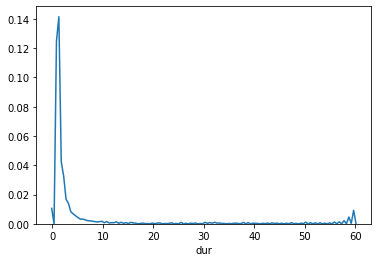

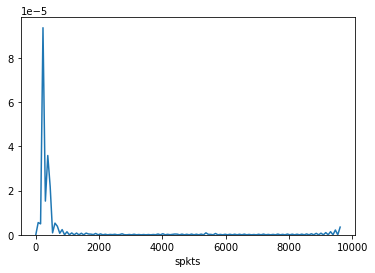

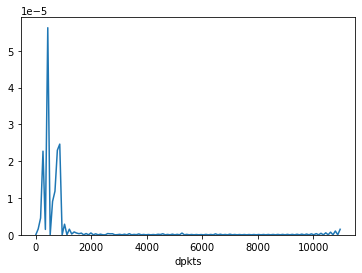

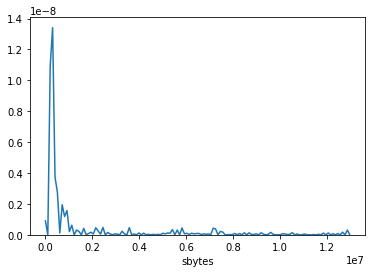

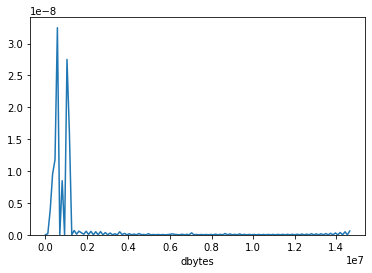

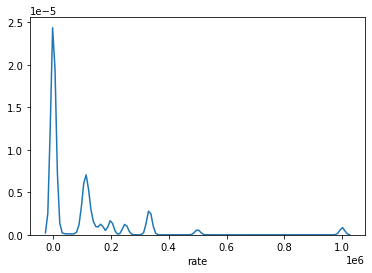

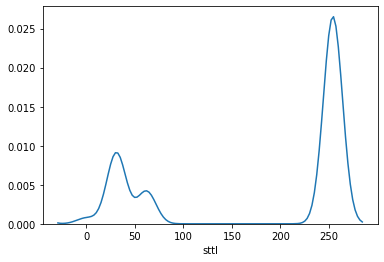

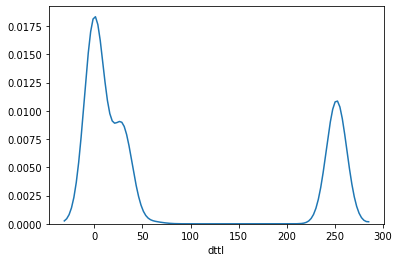

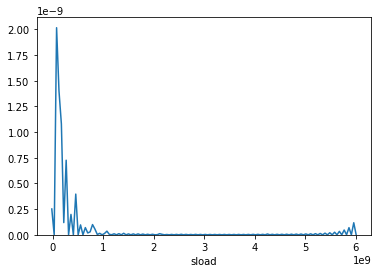

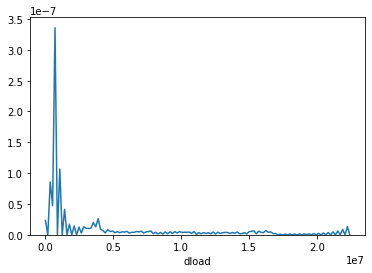

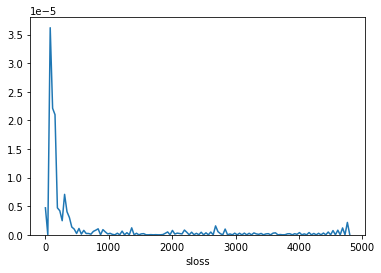

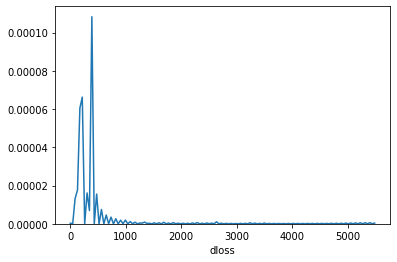

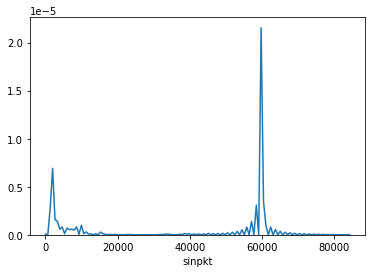

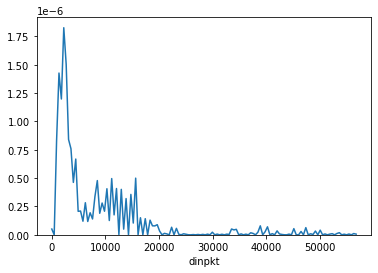

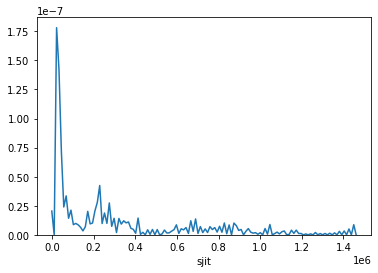

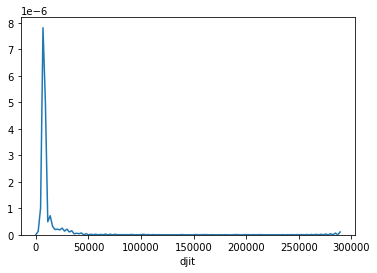

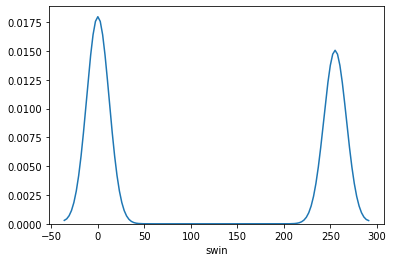

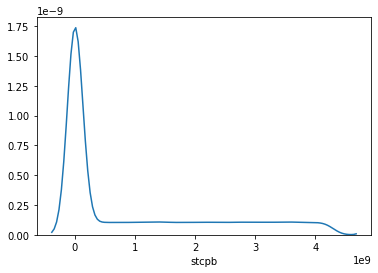

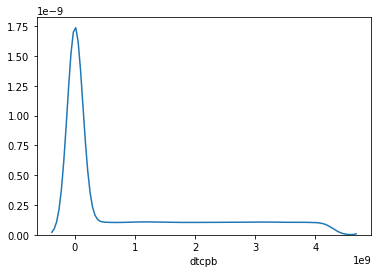

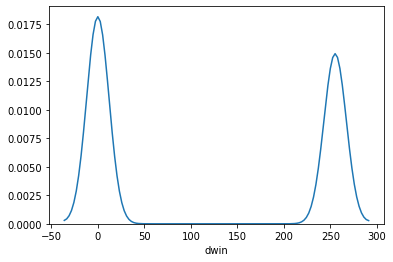

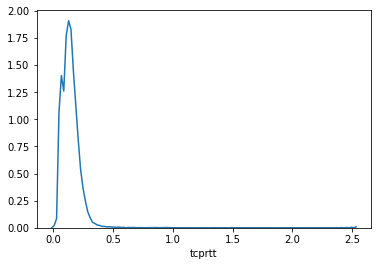

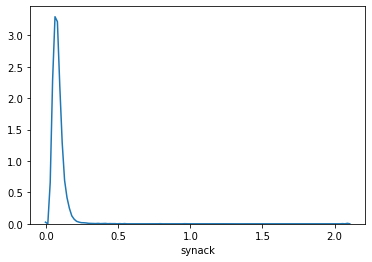

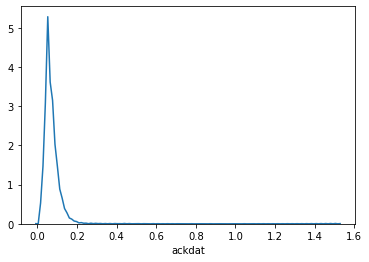

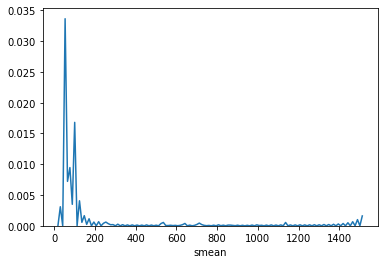

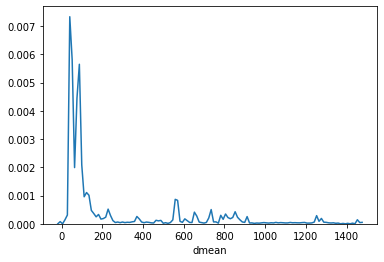

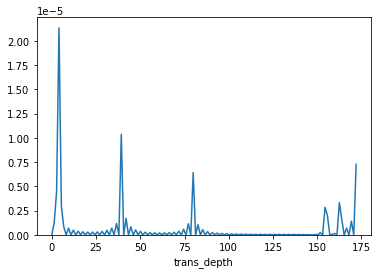

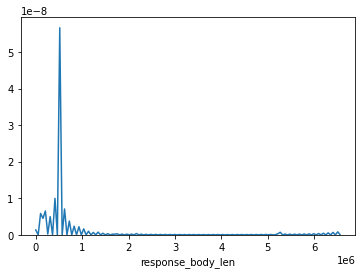

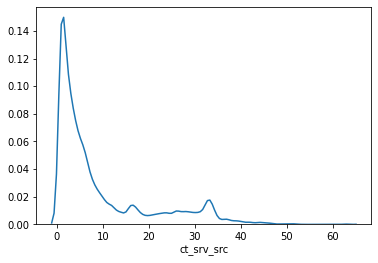

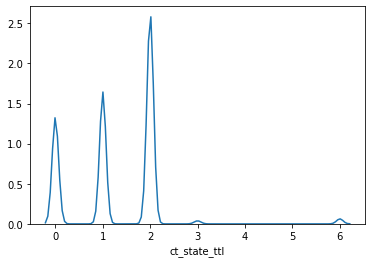

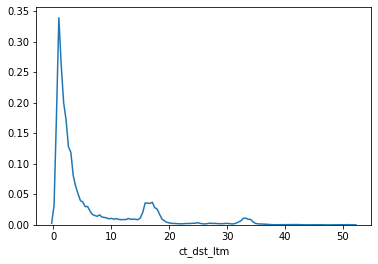

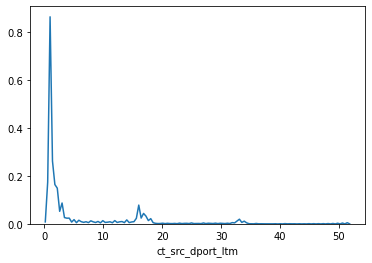

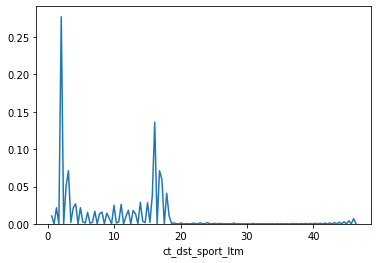

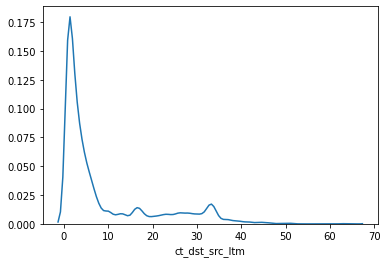

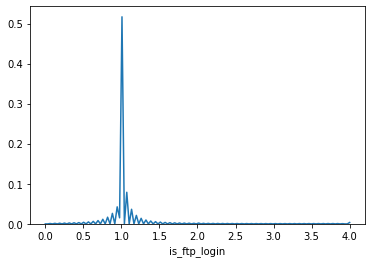

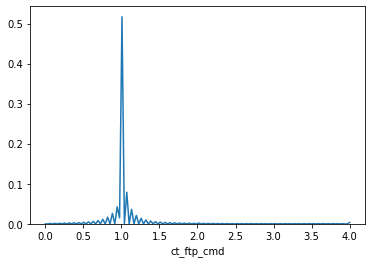

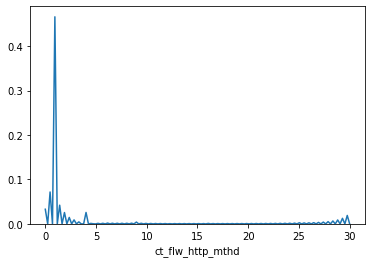

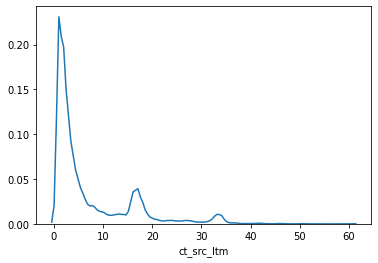

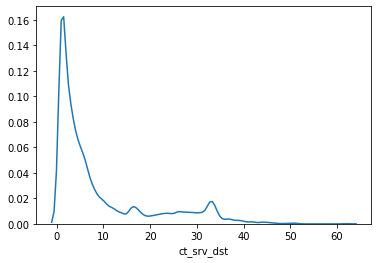

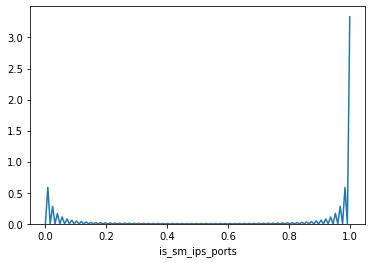

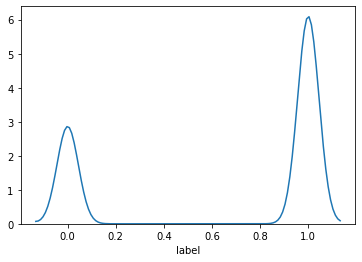

In [ ]:
#Graphs
df=pd.read_csv('UNSW_NB15_training-set.csv',index_col='id')
df=df.drop(['attack_cat','proto','service','state'], axis=1)
col=df.columns
for i in range(len(col)):
    plotfig(col[i])

In [ ]:
def preprocess_initial(df):
    
    dummies1 = pd.get_dummies(data['proto'],drop_first= True)
    dummies2 = pd.get_dummies(data['service'],drop_first= True)
    dummies3 = pd.get_dummies(data['state'],drop_first= True)
    
    
    right = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', "rate",  "dttl",
           'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
            'djit',"swin", 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
             'ackdat', 'smean', 'dmean','ct_srv_src', 'ct_dst_ltm', 
             'ct_src_dport_ltm', 'ct_dst_sport_ltm','ct_dst_src_ltm', 
             'ct_src_ltm', 'ct_srv_dst']
    
    left = ["sttl",'ct_state_ttl']
    
    for i in left:
        df[i] = df[i]**3
        #df[i] = df[i]**2
        
    for i in right:
        df[i] = (df[i]+1).transform(np.log)
        #df[i], _ = stats.boxcox(df[i]+1) 
    
    df        = pd.concat([dummies1, dummies2, dummies3, df], axis=1)
    df       = df.drop(['attack_cat','proto','service','state'], axis=1)
    return df

In [ ]:
def preprocess_final(X_train, X_test, y_train, y_test):
    
    power = PowerTransformer()
    X_train = power.fit_transform(X_train)
    X_test = power.transform(X_test)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [ ]:
def f_score(X_train, X_test, y_train, y_test):
    
    model = XGBClassifier(silent=True,
                      booster = 'gbtree',
                     objective='binary:logistic',
                      n_estimators=5000, 
                        learning_rate = 0.05,
                      max_depth=10,
                        verbosity=0
                     )
    eval_set = [(X_test, y_test)]
    eval_metric = ["logloss"]
    model.fit(X_train, y_train,early_stopping_rounds=50, eval_metric=eval_metric, eval_set=eval_set)
    
    yxgb=model.predict(X_test)
    f_weighted = f1_score(y_true=y_test,y_pred=yxgb,average="weighted")
    f_macro = f1_score(y_true=y_test,y_pred=yxgb,average="macro")
    acc = accuracy_score(y_true=y_test,y_pred=yxgb)
    return (f_weighted,f_macro,acc)

In [ ]:
def category(X,y):
    
    l_w = []
    l_m = []
    l_a = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    fold = 0
    for train_ix, test_ix in kfold.split(X, y):
        fold+=1
        
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        X_train, X_test, y_train, y_test = preprocess_final(X_train, X_test, y_train, y_test)
        
        score_w,score_m,score_a  = f_score(X_train, X_test, y_train, y_test)
        l_w.append(score_w)
        l_m.append(score_m)
        l_a.append(score_a)
            
        print(f"Completed Fold{fold}")
    
    return sum(l_w)/len(l_w) , sum(l_m)/len(l_m) , sum(l_a)/len(l_a)

In [ ]:
df_final = preprocess_initial(data)
train_y  = df_final['label']
train_x  = df_final.drop(['label'],axis=1)

result1, result2, result3 = category(train_x.values,train_y.values)

[0]	validation_0-logloss:0.651529
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.613901
[2]	validation_0-logloss:0.579546
[3]	validation_0-logloss:0.548088
[4]	validation_0-logloss:0.519423
[5]	validation_0-logloss:0.493051
[6]	validation_0-logloss:0.468726
[7]	validation_0-logloss:0.446242
[8]	validation_0-logloss:0.425546
[9]	validation_0-logloss:0.406173
[10]	validation_0-logloss:0.388248
[11]	validation_0-logloss:0.371424
[12]	validation_0-logloss:0.355735
[13]	validation_0-logloss:0.341267
[14]	validation_0-logloss:0.32768
[15]	validation_0-logloss:0.314985
[16]	validation_0-logloss:0.302924
[17]	validation_0-logloss:0.291675
[18]	validation_0-logloss:0.281129
[19]	validation_0-logloss:0.271297
[20]	validation_0-logloss:0.261965
[21]	validation_0-logloss:0.253288
[22]	validation_0-logloss:0.245013
[23]	validation_0-logloss:0.237246
[24]	validation_0-logloss:0.229938
[25]	validation_0-logloss:0.222996
[26]	validation_0-logloss:0.21652

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Streaming output truncated to the last 5000 lines.
[641]	validation_0-logloss:0.084321
[642]	validation_0-logloss:0.084298
[643]	validation_0-logloss:0.084264
[644]	validation_0-logloss:0.084312
[645]	validation_0-logloss:0.084327
[646]	validation_0-logloss:0.084343
[647]	validation_0-logloss:0.084347
[648]	validation_0-logloss:0.084341
[649]	validation_0-logloss:0.084274
[650]	validation_0-logloss:0.084274
[651]	validation_0-logloss:0.084274
[652]	validation_0-logloss:0.084285
[653]	validation_0-logloss:0.084291
[654]	validation_0-logloss:0.084302
[655]	validation_0-logloss:0.084315
[656]	validation_0-logloss:0.084294
[657]	validation_0-logloss:0.08428
[658]	validation_0-logloss:0.084244
[659]	validation_0-logloss:0.084234
[660]	validation_0-logloss:0.084229
[661]	validation_0-logloss:0.084207
[662]	validation_0-logloss:0.084211
[663]	validation_0-logloss:0.084195
[664]	validation_0-logloss:0.084192
[665]	validation_0-logloss:0.084188
[666]	validation_0-logloss:0.084184
[667]	validati

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[0]	validation_0-logloss:0.651617
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.614101
[2]	validation_0-logloss:0.579937
[3]	validation_0-logloss:0.548725
[4]	validation_0-logloss:0.520025
[5]	validation_0-logloss:0.493679
[6]	validation_0-logloss:0.469499
[7]	validation_0-logloss:0.447
[8]	validation_0-logloss:0.426366
[9]	validation_0-logloss:0.406837
[10]	validation_0-logloss:0.389055
[11]	validation_0-logloss:0.372376
[12]	validation_0-logloss:0.356776
[13]	validation_0-logloss:0.342345
[14]	validation_0-logloss:0.328715
[15]	validation_0-logloss:0.316047
[16]	validation_0-logloss:0.304107
[17]	validation_0-logloss:0.292903
[18]	validation_0-logloss:0.282374
[19]	validation_0-logloss:0.272574
[20]	validation_0-logloss:0.263238
[21]	validation_0-logloss:0.254585
[22]	validation_0-logloss:0.246346
[23]	validation_0-logloss:0.238635
[24]	validation_0-logloss:0.231383
[25]	validation_0-logloss:0.22452
[26]	validation_0-logloss:0.217983
[

Weighted

In [ ]:
result1

0.9635168415443444

Macro

In [ ]:
result2

0.9578815542814297

Acc

In [ ]:
result3

0.9636593764840411

# After Feature Selection

In [ ]:
df_final = preprocess_initial(data)
train_y  = df_final['label']
train_x  = df_final.drop(['label'],axis=1)
bin1 = sorted([(i,j,k) for j,i,k in zip(f_classif(train_x, train_y)[0],f_classif(train_x, train_y)[1],train_x.columns)],key = lambda x: (x[0],-x[1]))
bin1

[(0.0, 130508.97235505967, 'sttl'),
 (0.0, 77460.96280031546, 'dload'),
 (0.0, 64599.6960514644, 'dmean'),
 (0.0, 61481.060966977246, 'dbytes'),
 (0.0, 59703.33285994361, 'INT'),
 (0.0, 53992.52761530672, 'dpkts'),
 (0.0, 37037.412174958066, 'ct_dst_sport_ltm'),
 (0.0, 34906.86311093543, 'dloss'),
 (0.0, 31066.294812994798, 'dttl'),
 (0.0, 27072.56469770108, 'sloss'),
 (0.0, 25007.032739295846, 'spkts'),
 (0.0, 23188.71222214385, 'ct_src_dport_ltm'),
 (0.0, 21975.51803988375, 'tcp'),
 (0.0, 21973.27169163021, 'swin'),
 (0.0, 19983.366379116273, 'stcpb'),
 (0.0, 19956.87204062203, 'dwin'),
 (0.0, 19942.340929764454, 'dtcpb'),
 (0.0, 18362.733022761324, 'sbytes'),
 (0.0, 17765.07828754023, 'FIN'),
 (0.0, 14306.866575710283, 'sload'),
 (0.0, 11377.151264398573, 'ct_dst_src_ltm'),
 (0.0, 10236.51786391375, 'sjit'),
 (0.0, 9280.836574293331, 'djit'),
 (0.0, 8705.376446429913, 'rate'),
 (0.0, 8072.298756787505, 'dns'),
 (0.0, 6420.504454216441, 'arp'),
 (0.0, 6309.110652735729, 'unas'),
 (0.

In [ ]:
imp = [i[2] for i in bin1][:30]

In [ ]:
result1, result2, result3 = category(train_x[imp].values,train_y.values)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[0]	validation_0-logloss:0.651823
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.614455
[2]	validation_0-logloss:0.580355
[3]	validation_0-logloss:0.549195
[4]	validation_0-logloss:0.520696
[5]	validation_0-logloss:0.494607
[6]	validation_0-logloss:0.470607
[7]	validation_0-logloss:0.448318
[8]	validation_0-logloss:0.427928
[9]	validation_0-logloss:0.408774
[10]	validation_0-logloss:0.391204
[11]	validation_0-logloss:0.374826
[12]	validation_0-logloss:0.359348
[13]	validation_0-logloss:0.345195
[14]	validation_0-logloss:0.331859
[15]	validation_0-logloss:0.319328
[16]	validation_0-logloss:0.307498
[17]	validation_0-logloss:0.296447
[18]	validation_0-logloss:0.286058
[19]	validation_0-logloss:0.276358
[20]	validation_0-logloss:0.26721
[21]	validation_0-logloss:0.258555
[22]	validation_0-logloss:0.250418
[23]	validation_0-logloss:0.242831
[24]	validation_0-logloss:0.235546
[25]	validation_0-logloss:0.228811
[26]	validation_0-logloss:0.22228

KeyboardInterrupt: ignored

In [ ]:
result1